### Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import BertTokenizer #, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import torch
import json
import os

os.environ["WANDB_DISABLED"] = "true"

C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Random Seeds

In [2]:
import random
from transformers import set_seed

# Set the random seed for reproducibility
seed = 42  # You can use any integer value
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU
set_seed(seed)  # For transformers

### Load dataset

Condition
- 0: F2F
- 1: Online

In [44]:
# Transcript and prediction targets
video_path = "E:/GAR/videos"
df = {rnd: pd.read_csv(os.path.join(video_path, f"G4_{rnd}_tsrc_whisper.csv")) for rnd in ['R1', 'R2', 'R3']}

# Some F2F courses were mistakenly recorded as Online Courses
df['R1'].loc[df['R1']['Video names'] == 'G4 Online Cotulla David Rodriguez Day 1 weather', 'Condition'] = 0
df['R1'].loc[df['R1']['Video names'] == 'G4 Online Jim Hogg Aaron Salazar Week 3 Day 1.mp4', 'Condition'] = 0
df['R1'].loc[df['R1']['Video names'] == 'G4 Online Kopperl Debbie Beavers', 'Condition'] = 0

### Define the functions

In [7]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    precision = precision_score(labels, predictions, average='weighted', zero_division=1)
    recall = recall_score(labels, predictions, average='weighted', zero_division=1)
    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [38]:
from datasets import Dataset
import joblib

def tokenize_and_save(df, target, rnd, setting, video_path, results_dir, dataset_dir):
    
    # df = df[rnd]
    df = df[df['Condition'] == setting][['tsrc', target]]
    df = df.fillna(' ')

    # Encode the target column
    label_encoder = LabelEncoder()
    df["label"] = label_encoder.fit_transform(df[target])
    
    # Save the label mapping to a JSON file
    label_mapping = {index: str(label) for index, label in enumerate(label_encoder.classes_)}
    mapping_file_path = os.path.join(results_dir, "encoded_to_original_label.json")
    with open(mapping_file_path, "w") as json_file:
        json.dump(label_mapping, json_file, indent=4)
    print(f"Label mapping saved to: {mapping_file_path}")
    
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    
    def tokenize_function(example):
        return tokenizer(example["tsrc"], truncation=True, padding="max_length", max_length=128)

    # Split dataset
    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)
    
    for split, dataset in zip(["train", "val", "test"], [train_df, val_df, test_df]):
        dataset = Dataset.from_pandas(dataset)  # Convert DataFrame to Dataset
        dataset = dataset.map(tokenize_function, batched=True)  # Now `batched=True` works
        dataset = dataset.remove_columns(["tsrc"])
        dataset.set_format("numpy")
        joblib.dump(dataset, os.path.join(dataset_dir, f"{split}_dataset.joblib"))

    tokenizer.save_pretrained(results_dir)  # Save tokenizer
    
    return df

In [39]:
from sklearn.ensemble import RandomForestClassifier

def training_evaluation(video_path, results_dir, output_dir):
    
    # Load tokenized datasets
    train_dataset = joblib.load(os.path.join(dataset_dir, "train_dataset.joblib"))
    val_dataset = joblib.load(os.path.join(dataset_dir, "val_dataset.joblib"))
    test_dataset = joblib.load(os.path.join(dataset_dir, "test_dataset.joblib"))
    
    train_features, train_labels = np.array(train_dataset["input_ids"].tolist()), np.array(train_dataset["label"].tolist())
    val_features, val_labels = np.array(val_dataset["input_ids"].tolist()), np.array(val_dataset["label"].tolist())
    test_features, test_labels = np.array(test_dataset["input_ids"].tolist()), np.array(test_dataset["label"].tolist())
    
    # Train Random Forest Model
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
    rf_model.fit(train_features, train_labels)
    
    # Save the trained model using joblib's dump function
    joblib.dump(rf_model, os.path.join(output_dir, "random_forest_model.joblib"))
    
    # Evaluate Model
    predictions = rf_model.predict(test_features)
    metrics = {
        "accuracy": accuracy_score(test_labels, predictions),
        "precision": precision_score(test_labels, predictions, average="weighted", zero_division=1),
        "recall": recall_score(test_labels, predictions, average="weighted", zero_division=1),
        "f1": f1_score(test_labels, predictions, average="weighted")
    }
    with open(os.path.join(results_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(results_dir, "confusion_matrix.png"))
    plt.show()
    plt.close()
    
    print("Evaluation Metrics:", metrics)





---------------------- Tokenize and save dataset R123, Setting 0, ESL Strategy ----------------------
Label mapping saved to: ./results0227_rf_2/R123/0/ESL Strategy\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 749/749 [00:00<00:00, 2407.91 examples/s]


<Figure size 1000x800 with 0 Axes>

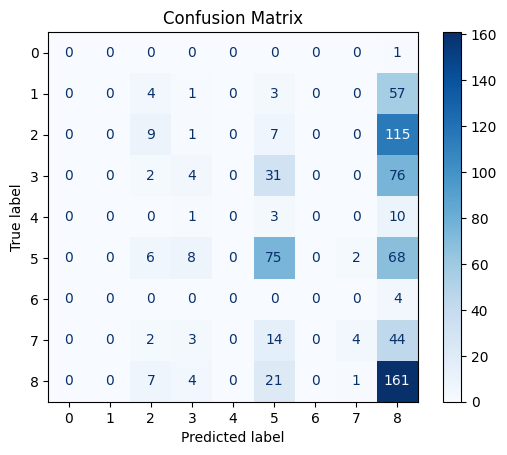

Evaluation Metrics: {'accuracy': 0.3377837116154873, 'precision': 0.42475116398656243, 'recall': 0.3377837116154873, 'f1': 0.254174755691622}



---------------------- Tokenize and save dataset R123, Setting 0, Curriculum ----------------------
Label mapping saved to: ./results0227_rf_2/R123/0/Curriculum\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 749/749 [00:00<00:00, 2435.38 examples/s]


<Figure size 1000x800 with 0 Axes>

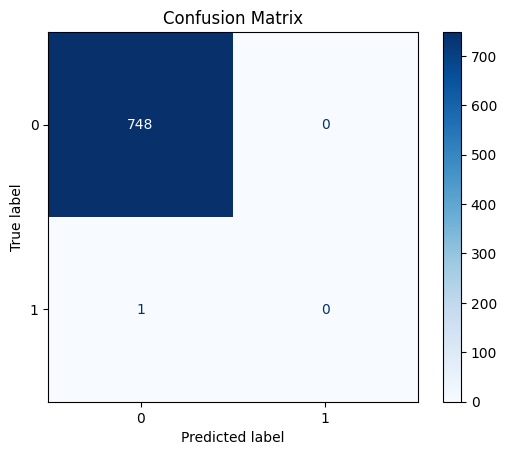

Evaluation Metrics: {'accuracy': 0.9986648865153538, 'precision': 0.9986666690433706, 'recall': 0.9986648865153538, 'f1': 0.9979977757027183}



---------------------- Tokenize and save dataset R123, Setting 0, Physical Group ----------------------
Label mapping saved to: ./results0227_rf_2/R123/0/Physical Group\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 749/749 [00:00<00:00, 2645.60 examples/s]


<Figure size 1000x800 with 0 Axes>

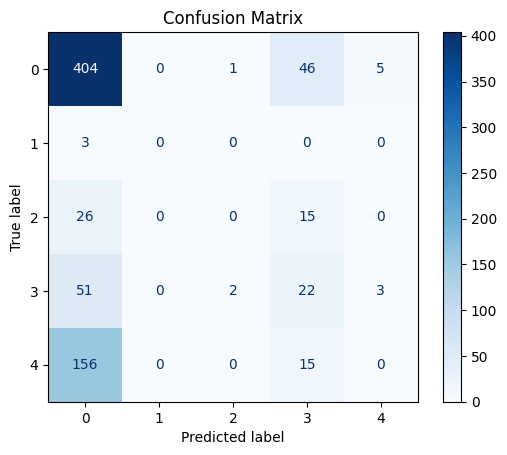

Evaluation Metrics: {'accuracy': 0.5687583444592791, 'precision': 0.41169586659764035, 'recall': 0.5687583444592791, 'f1': 0.47486673228538295}



---------------------- Tokenize and save dataset R123, Setting 0, Activity Structure ----------------------
Label mapping saved to: ./results0227_rf_2/R123/0/Activity Structure\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 749/749 [00:00<00:00, 2617.89 examples/s]


<Figure size 1000x800 with 0 Axes>

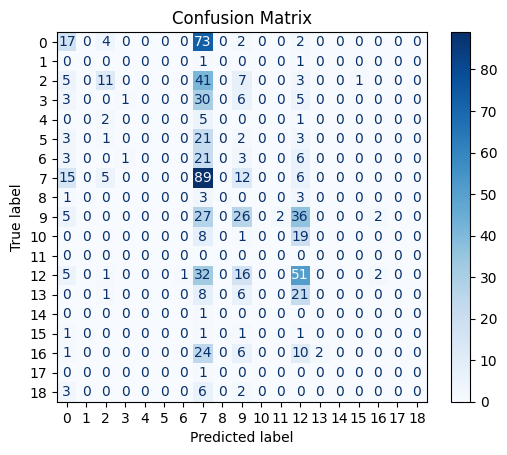

Evaluation Metrics: {'accuracy': 0.260347129506008, 'precision': 0.3434205297893595, 'recall': 0.260347129506008, 'f1': 0.19946886736509103}



---------------------- Tokenize and save dataset R123, Setting 0, Mode ----------------------
Label mapping saved to: ./results0227_rf_2/R123/0/Mode\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 749/749 [00:00<00:00, 2446.05 examples/s]


<Figure size 1000x800 with 0 Axes>

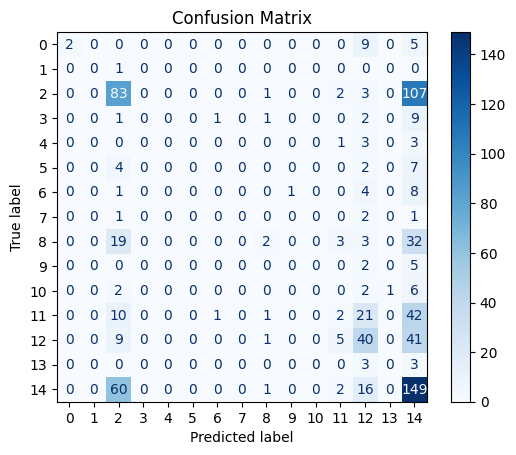

Evaluation Metrics: {'accuracy': 0.3711615487316422, 'precision': 0.39232980767871967, 'recall': 0.3711615487316422, 'f1': 0.3159559921906148}



---------------------- Tokenize and save dataset R123, Setting 0, Language Content ----------------------
Label mapping saved to: ./results0227_rf_2/R123/0/Language Content\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 749/749 [00:00<00:00, 2570.38 examples/s]


<Figure size 1000x800 with 0 Axes>

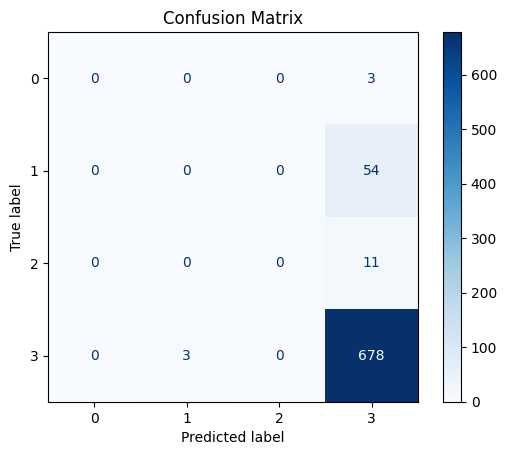

Evaluation Metrics: {'accuracy': 0.9052069425901201, 'precision': 0.845026612784875, 'recall': 0.9052069425901201, 'f1': 0.8639746712037447}



---------------------- Tokenize and save dataset R123, Setting 0, Lang. of Instruction(T) ----------------------
Label mapping saved to: ./results0227_rf_2/R123/0/Lang. of Instruction(T)\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 749/749 [00:00<00:00, 2585.14 examples/s]


<Figure size 1000x800 with 0 Axes>

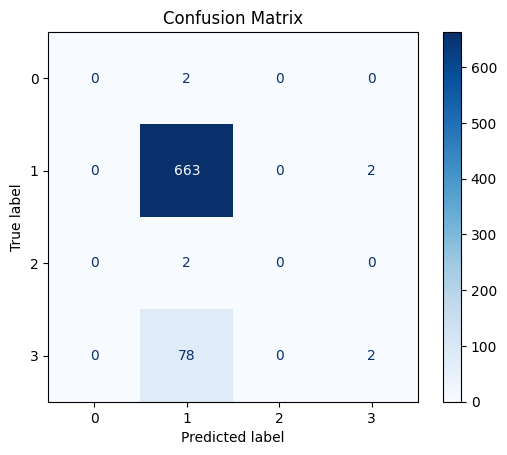

Evaluation Metrics: {'accuracy': 0.8878504672897196, 'precision': 0.8488723219325992, 'recall': 0.8878504672897196, 'f1': 0.8400433945699974}



---------------------- Tokenize and save dataset R123, Setting 0, Lang. of Instruction(S) ----------------------
Label mapping saved to: ./results0227_rf_2/R123/0/Lang. of Instruction(S)\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 749/749 [00:00<00:00, 2576.54 examples/s]


<Figure size 1000x800 with 0 Axes>

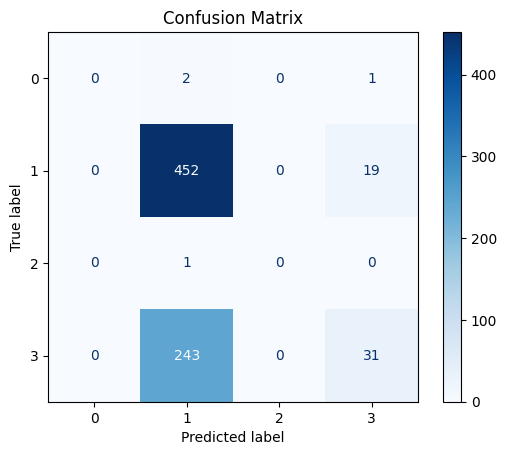

Evaluation Metrics: {'accuracy': 0.6448598130841121, 'precision': 0.6349157342287798, 'recall': 0.6448598130841121, 'f1': 0.5560747997395663}



---------------------- Tokenize and save dataset R123, Setting 1, ESL Strategy ----------------------
Label mapping saved to: ./results0227_rf_2/R123/1/ESL Strategy\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 2478.94 examples/s]


<Figure size 1000x800 with 0 Axes>

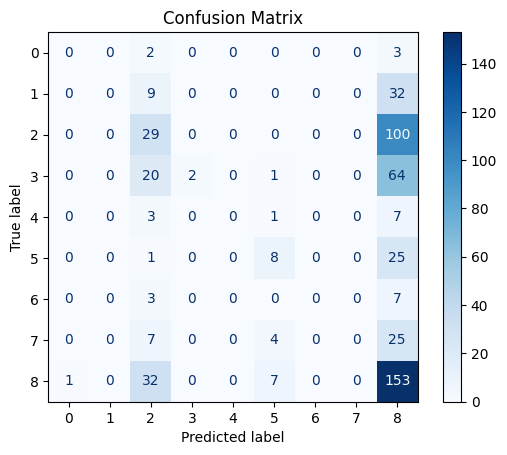

Evaluation Metrics: {'accuracy': 0.3516483516483517, 'precision': 0.5571941517573127, 'recall': 0.3516483516483517, 'f1': 0.2611990637013336}



---------------------- Tokenize and save dataset R123, Setting 1, Curriculum ----------------------
Label mapping saved to: ./results0227_rf_2/R123/1/Curriculum\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 2492.83 examples/s]


<Figure size 1000x800 with 0 Axes>

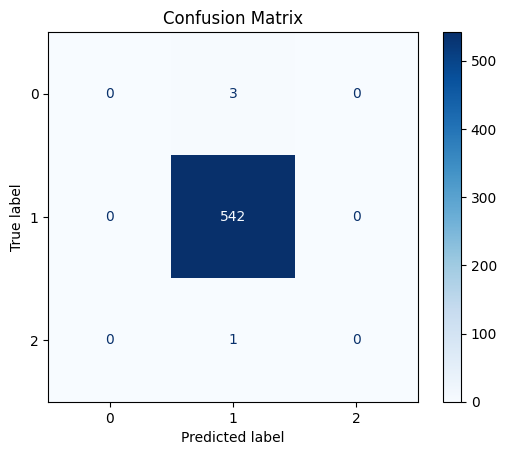

Evaluation Metrics: {'accuracy': 0.9926739926739927, 'precision': 0.9927276630573334, 'recall': 0.9926739926739927, 'f1': 0.9890244559362207}



---------------------- Tokenize and save dataset R123, Setting 1, Physical Group ----------------------
Label mapping saved to: ./results0227_rf_2/R123/1/Physical Group\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 2260.34 examples/s]


<Figure size 1000x800 with 0 Axes>

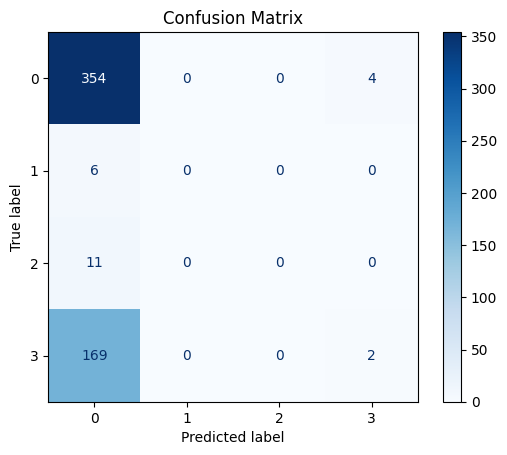

Evaluation Metrics: {'accuracy': 0.652014652014652, 'precision': 0.5653642653642653, 'recall': 0.652014652014652, 'f1': 0.5240261984061765}



---------------------- Tokenize and save dataset R123, Setting 1, Activity Structure ----------------------
Label mapping saved to: ./results0227_rf_2/R123/1/Activity Structure\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 2473.52 examples/s]


<Figure size 1000x800 with 0 Axes>

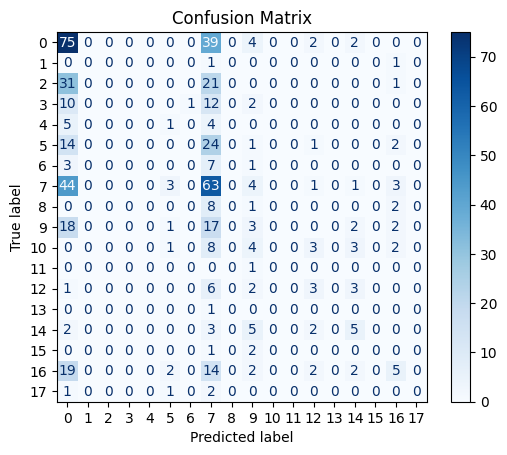

Evaluation Metrics: {'accuracy': 0.28205128205128205, 'precision': 0.41983785952996394, 'recall': 0.28205128205128205, 'f1': 0.20965488899977014}



---------------------- Tokenize and save dataset R123, Setting 1, Mode ----------------------
Label mapping saved to: ./results0227_rf_2/R123/1/Mode\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 2502.02 examples/s]


<Figure size 1000x800 with 0 Axes>

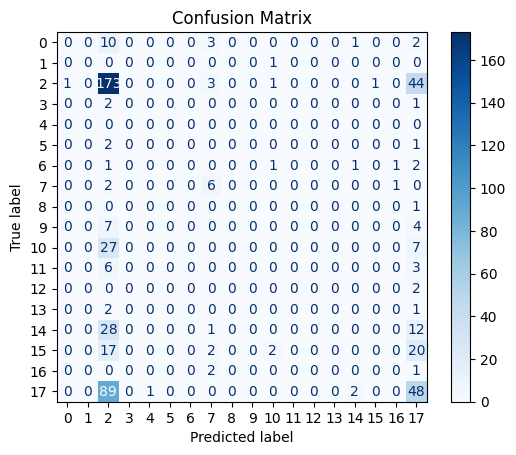

Evaluation Metrics: {'accuracy': 0.4157509157509158, 'precision': 0.3529015486342702, 'recall': 0.4157509157509158, 'f1': 0.332705748484241}



---------------------- Tokenize and save dataset R123, Setting 1, Language Content ----------------------
Label mapping saved to: ./results0227_rf_2/R123/1/Language Content\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 2392.18 examples/s]


<Figure size 1000x800 with 0 Axes>

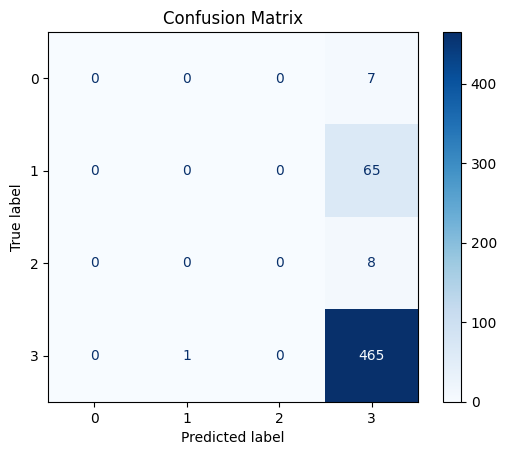

Evaluation Metrics: {'accuracy': 0.8516483516483516, 'precision': 0.7556709345700172, 'recall': 0.8516483516483516, 'f1': 0.7851001619547614}



---------------------- Tokenize and save dataset R123, Setting 1, Lang. of Instruction(T) ----------------------
Label mapping saved to: ./results0227_rf_2/R123/1/Lang. of Instruction(T)\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 2231.88 examples/s]


<Figure size 1000x800 with 0 Axes>

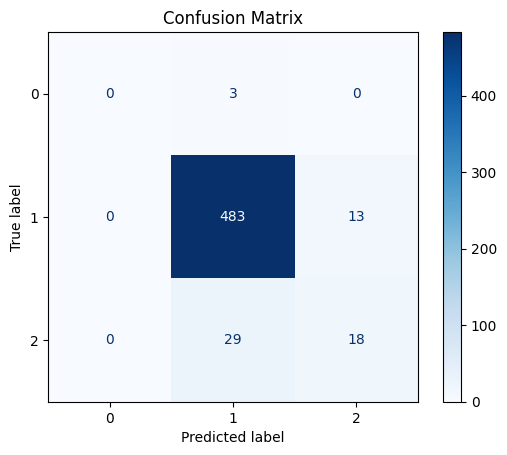

Evaluation Metrics: {'accuracy': 0.9175824175824175, 'precision': 0.9074558701555256, 'recall': 0.9175824175824175, 'f1': 0.9077200665879049}



---------------------- Tokenize and save dataset R123, Setting 1, Lang. of Instruction(S) ----------------------
Label mapping saved to: ./results0227_rf_2/R123/1/Lang. of Instruction(S)\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 2321.11 examples/s]


<Figure size 1000x800 with 0 Axes>

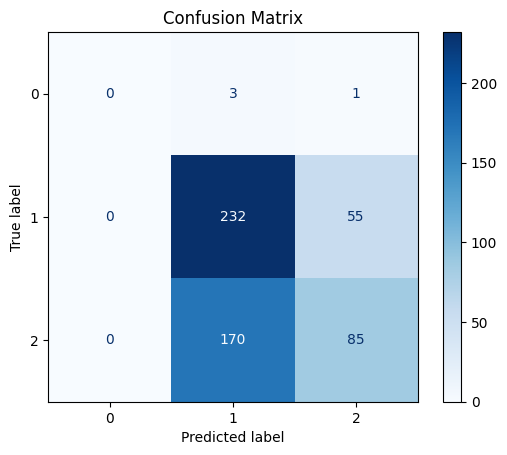

Evaluation Metrics: {'accuracy': 0.5805860805860806, 'precision': 0.5899786493167107, 'recall': 0.5805860805860806, 'f1': 0.5529468925422683}


In [45]:
data = list(df.keys())
settings = [0, 1]
y_cols = ['ESL Strategy', 'Curriculum', 'Physical Group',
          'Activity Structure', 'Mode', 'Language Content',
          'Lang. of Instruction(T)', 'Lang. of Instruction(S)']

df_merged = pd.concat([df['R1'], df['R2'], df['R3']])
df_merged = df_merged.reset_index(drop=True)

for rnd in ['R123']:
    for setting in settings:
        for target in y_cols:
            print(f"\n\n\n---------------------- Tokenize and save dataset {rnd}, Setting {setting}, {target} ----------------------")

            dataset_dir = f"./datasets0227_rf/{rnd}/{setting}/{target}"
            output_dir = f"./models0227_rf_2/{rnd}/{setting}/{target}"
            results_dir = f"./results0227_rf_2/{rnd}/{setting}/{target}"
            os.makedirs(dataset_dir, exist_ok=True)
            os.makedirs(output_dir, exist_ok=True)
            os.makedirs(results_dir, exist_ok=True)

            tokenize_and_save(df_merged, target, rnd, setting, video_path, results_dir, dataset_dir)
            training_evaluation(video_path, results_dir, output_dir)